In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import chirp
from scipy import signal


# # Number of sample points
# N = 1000

# # Sample spacing
# T = 1.0 / 800.0     # f = 800 Hz

# # Create a signal
# x = np.linspace(0.0, N*T, N)
# t0 = np.pi/6   # non-zero phase of the second sine
# y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(200.0 * 2.0*np.pi*x + t0)
# yf = np.fft.fft(y) # to normalize use norm='ortho' as an additional argument

# # Where is a 200 Hz frequency in the results?
# freq = np.fft.fftfreq(x.size, d=T)
# index, = np.where(np.isclose(freq, 200, atol=1/(T*N)))

# # Get magnitude and phase
# magnitude = np.abs(yf[index[0]])
# phase = np.angle(yf[index[0]])
# print("Magnitude:", magnitude, ", phase:", phase)

# # Plot a spectrum 
# plt.plot(freq[0:N//2], 2/N*np.abs(yf[0:N//2]), label='amplitude spectrum')   # in a conventional form
# plt.plot(freq[0:N//2], np.angle(yf[0:N//2]), label='phase spectrum')
# plt.legend()
# plt.grid()
# plt.show()

In [2]:
def TDFdirecta(x):
    
    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    
    X = np.dot(e, x)
    
    return X.imag, X.real, abs(X), np.angle(X.imag/X.real)

In [3]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [4]:
def tonegen(digitos, fs = 12000,  escala = 1):
    
    n_digitos = len(digitos) 
    
    ts = 1/fs
    
    signal_time = 0.02    
    t = np.arange(0, signal_time*n_digitos, ts) # signal duration of 20ms
         
    n_muestras = int(signal_time/ts)
    
    tonemisterio = np.zeros(n_digitos * n_muestras) # total length of the misterio signal
    
    # Primera componente de señales sinusoidales
    
    for i in range(len(digitos)):
        
        f = f_digitos[digitos[i]]
        
        a_interval = n_muestras*i
        b_interval = (n_muestras*i) + n_muestras
        tonemisterio[a_interval : b_interval] += escala*np.sin(2*np.pi*f*t[a_interval : b_interval])
    
    # Segunda componente de interferencia
    f0 = np.random.randint(1, int(fs/3))
    f1 = np.random.randint(1, int(fs/3))
    
    interferencia = chirp(t, f0 = f0, f1 = f1, t1 = t[int(len(t)/2)], method='linear')
    
    # Tercera componente ruido gaussiano blanco
    varianza_ruido = 0.04*5*escala # 4% of the amplitude of the interference signal
    ruido = np.random.normal(0, varianza_ruido, n_digitos * n_muestras)
    
    return tonemisterio, interferencia, ruido, t
    
    

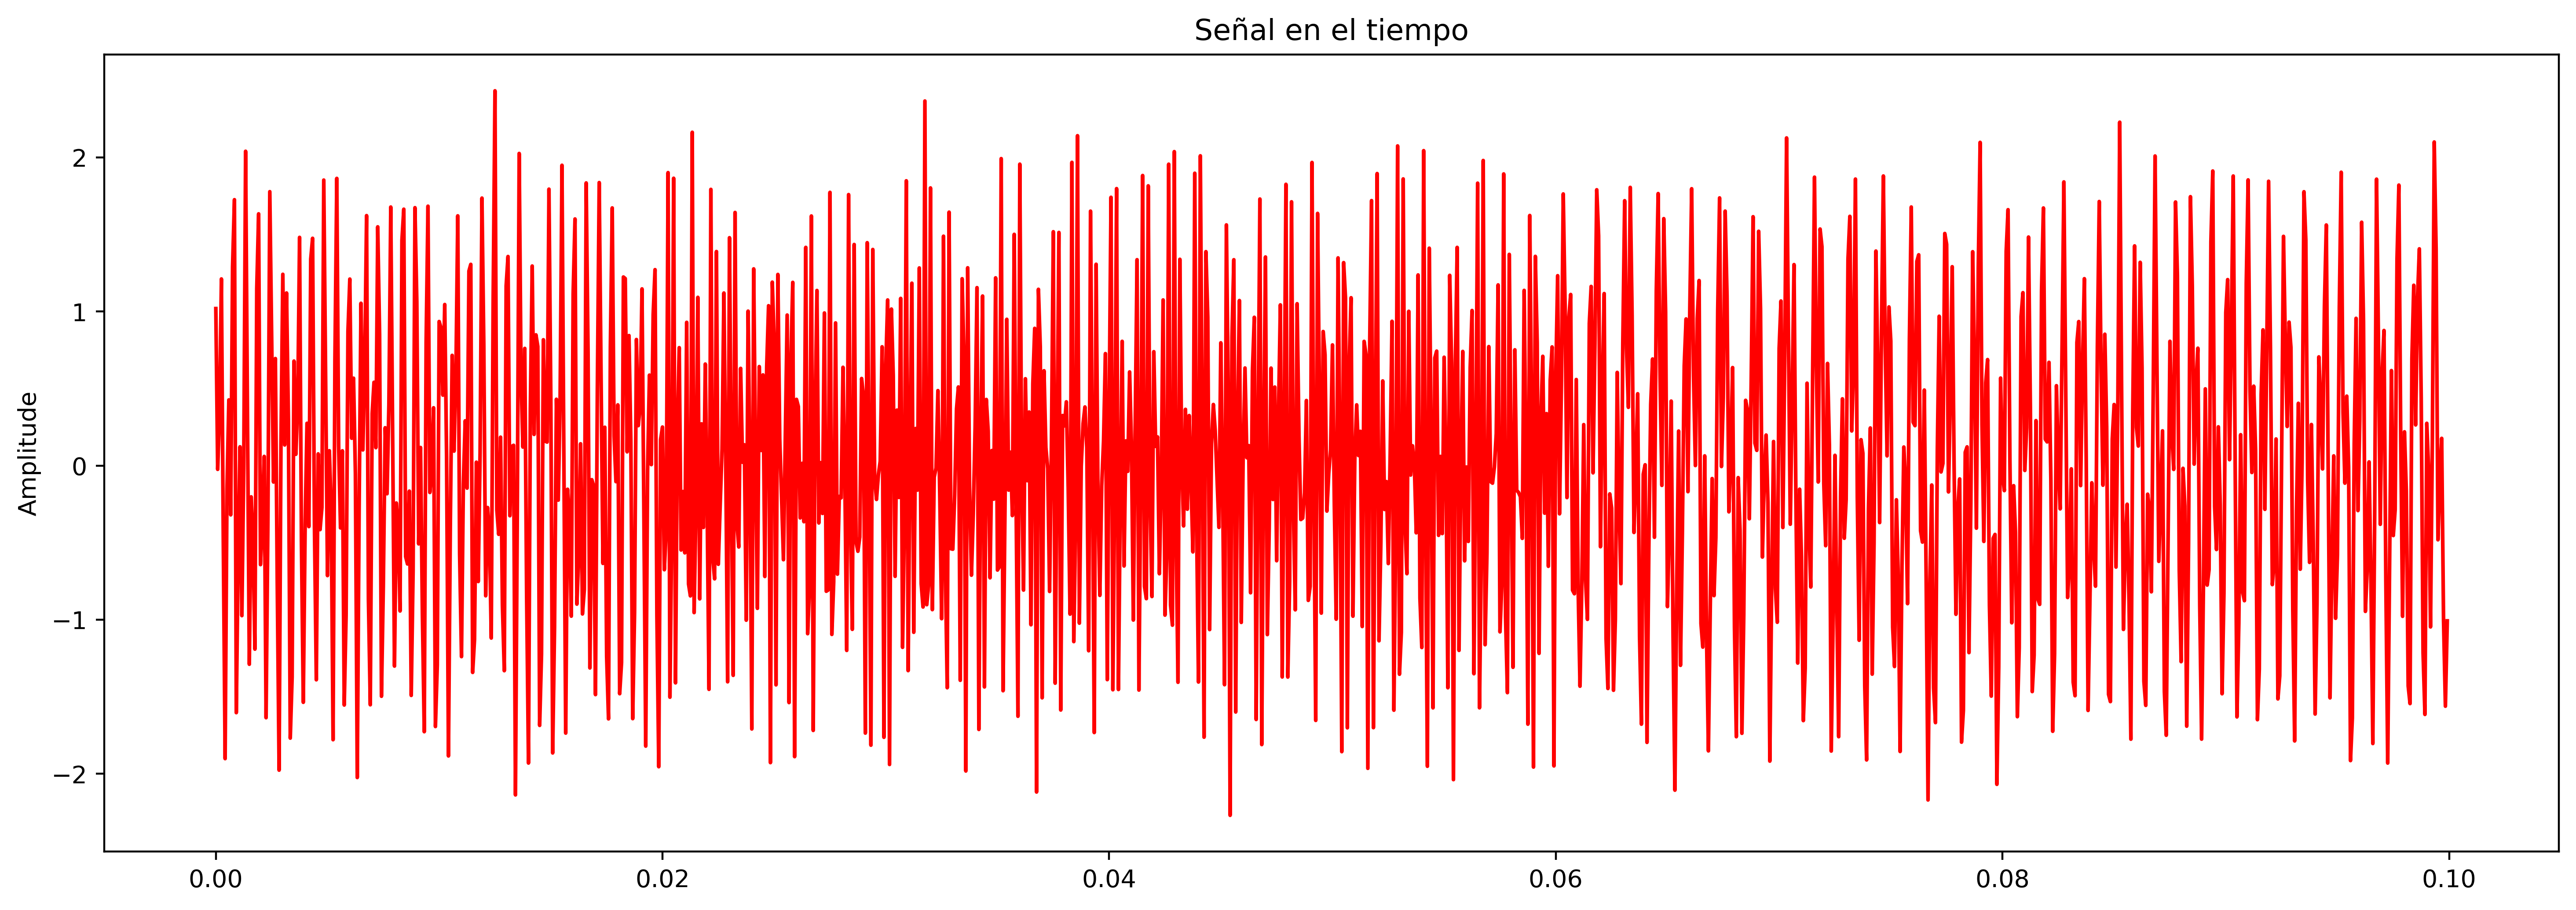

[Text(0.5, 0, 'Time (s)'), Text(0, 0.5, 'Frequency (Hz)')]

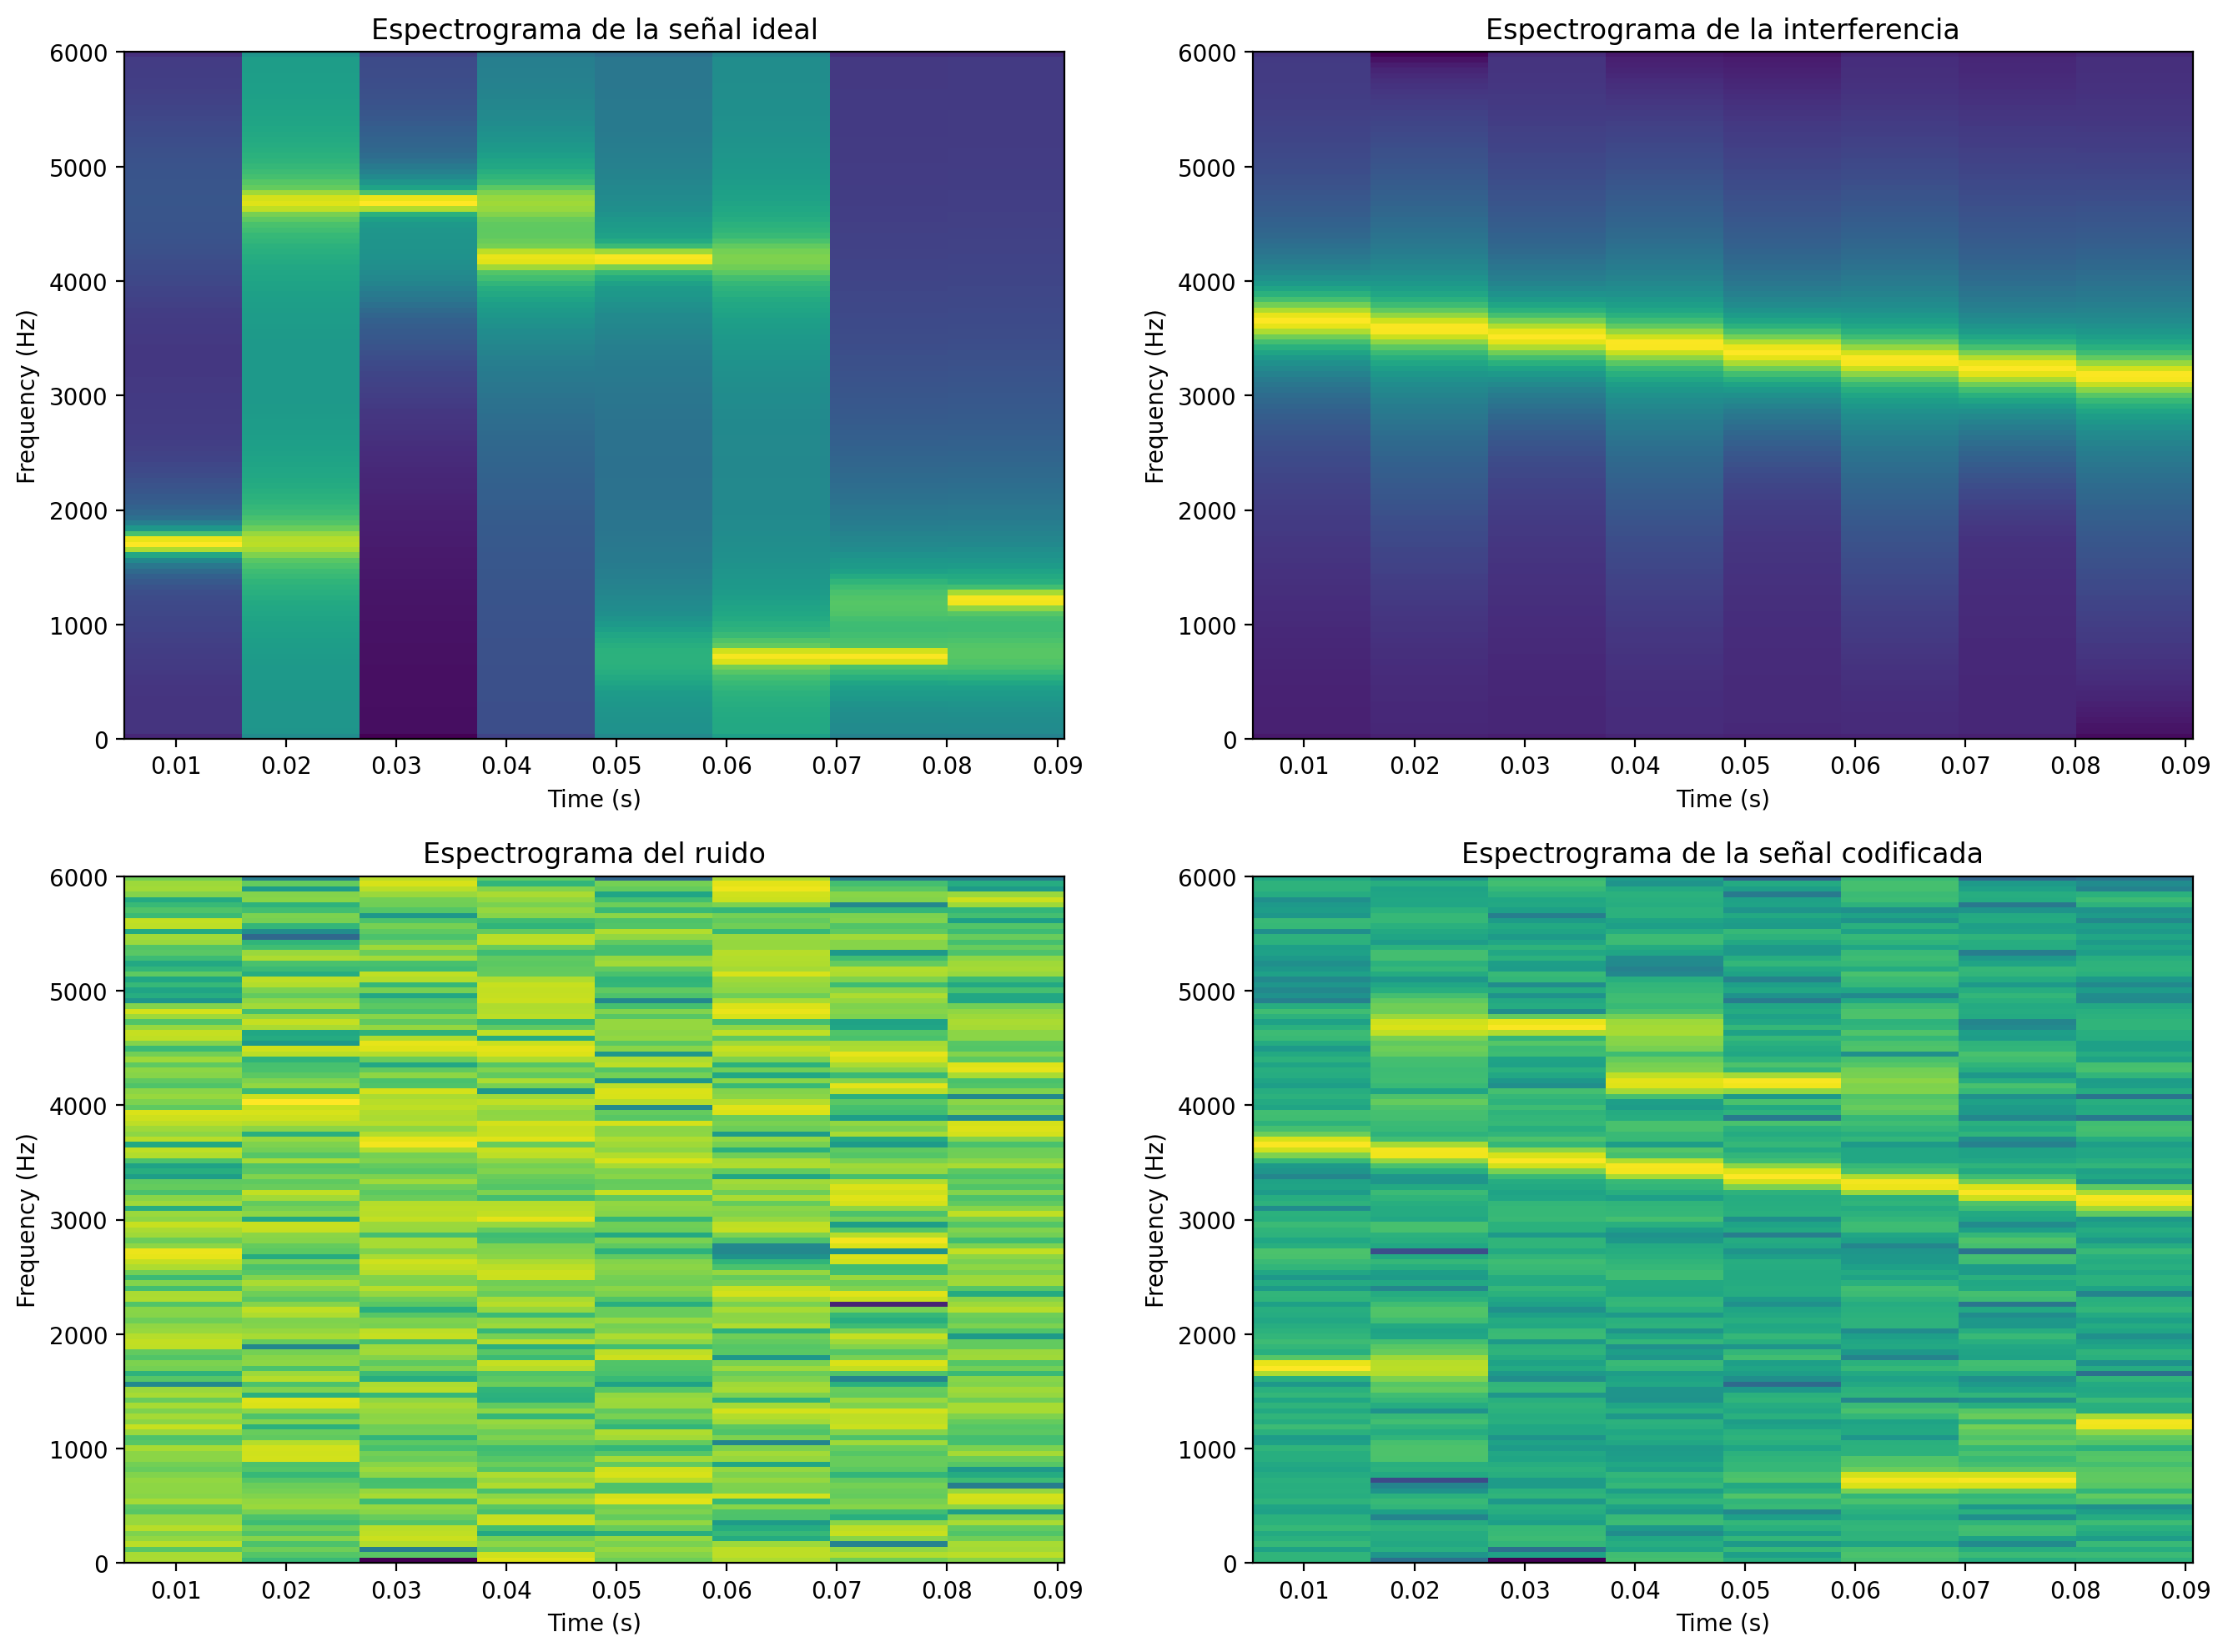

In [5]:
fs = 12000.0    # fs = 12 KHz

# N = len(Mag)
# n = np.arange(N)
# T = N/fs
# freq = n/T 

f_digitos = [200, 700, 1200, 1700, 2200, 2700, 3200, 3700, 4200, 4700]

digitos=[3, 9, 8, 1, 2]
n_digitos = len(digitos) 
    
tonemisterio, interferencia, ruido, t = tonegen(digitos, fs)

codificacion = tonemisterio + interferencia + ruido

plt.figure(figsize = (18, 6), dpi = 400)
plt.plot(t, codificacion, 'r')
plt.ylabel('Amplitude')
plt.title('Señal en el tiempo')

plt.show()

fig, ax = plt.subplots(2, 2, figsize=(16, 12), dpi = 200)

_, _, _, _ = ax[0,0].specgram(tonemisterio, Fs=fs, aspect = 'auto')
ax[0,0].set_title('Espectrograma de la señal ideal')
ax[0,0].set(xlabel='Time (s)', ylabel='Frequency (Hz)')

_, _, _, _ = ax[0,1].specgram(interferencia, Fs=fs, aspect='auto')
ax[0,1].set_title('Espectrograma de la interferencia')
ax[0,1].set(xlabel='Time (s)', ylabel='Frequency (Hz)')

_, _, _, _ = ax[1,0].specgram(ruido, Fs=fs, aspect='auto')
ax[1,0].set_title('Espectrograma del ruido')
ax[1,0].set(xlabel='Time (s)', ylabel='Frequency (Hz)')

_, _, _, _ = ax[1,1].specgram(codificacion, Fs=fs, aspect = 'auto')
ax[1,1].set_title('Espectrograma de la señal codificada')
ax[1,1].set(xlabel='Time (s)', ylabel='Frequency (Hz)')

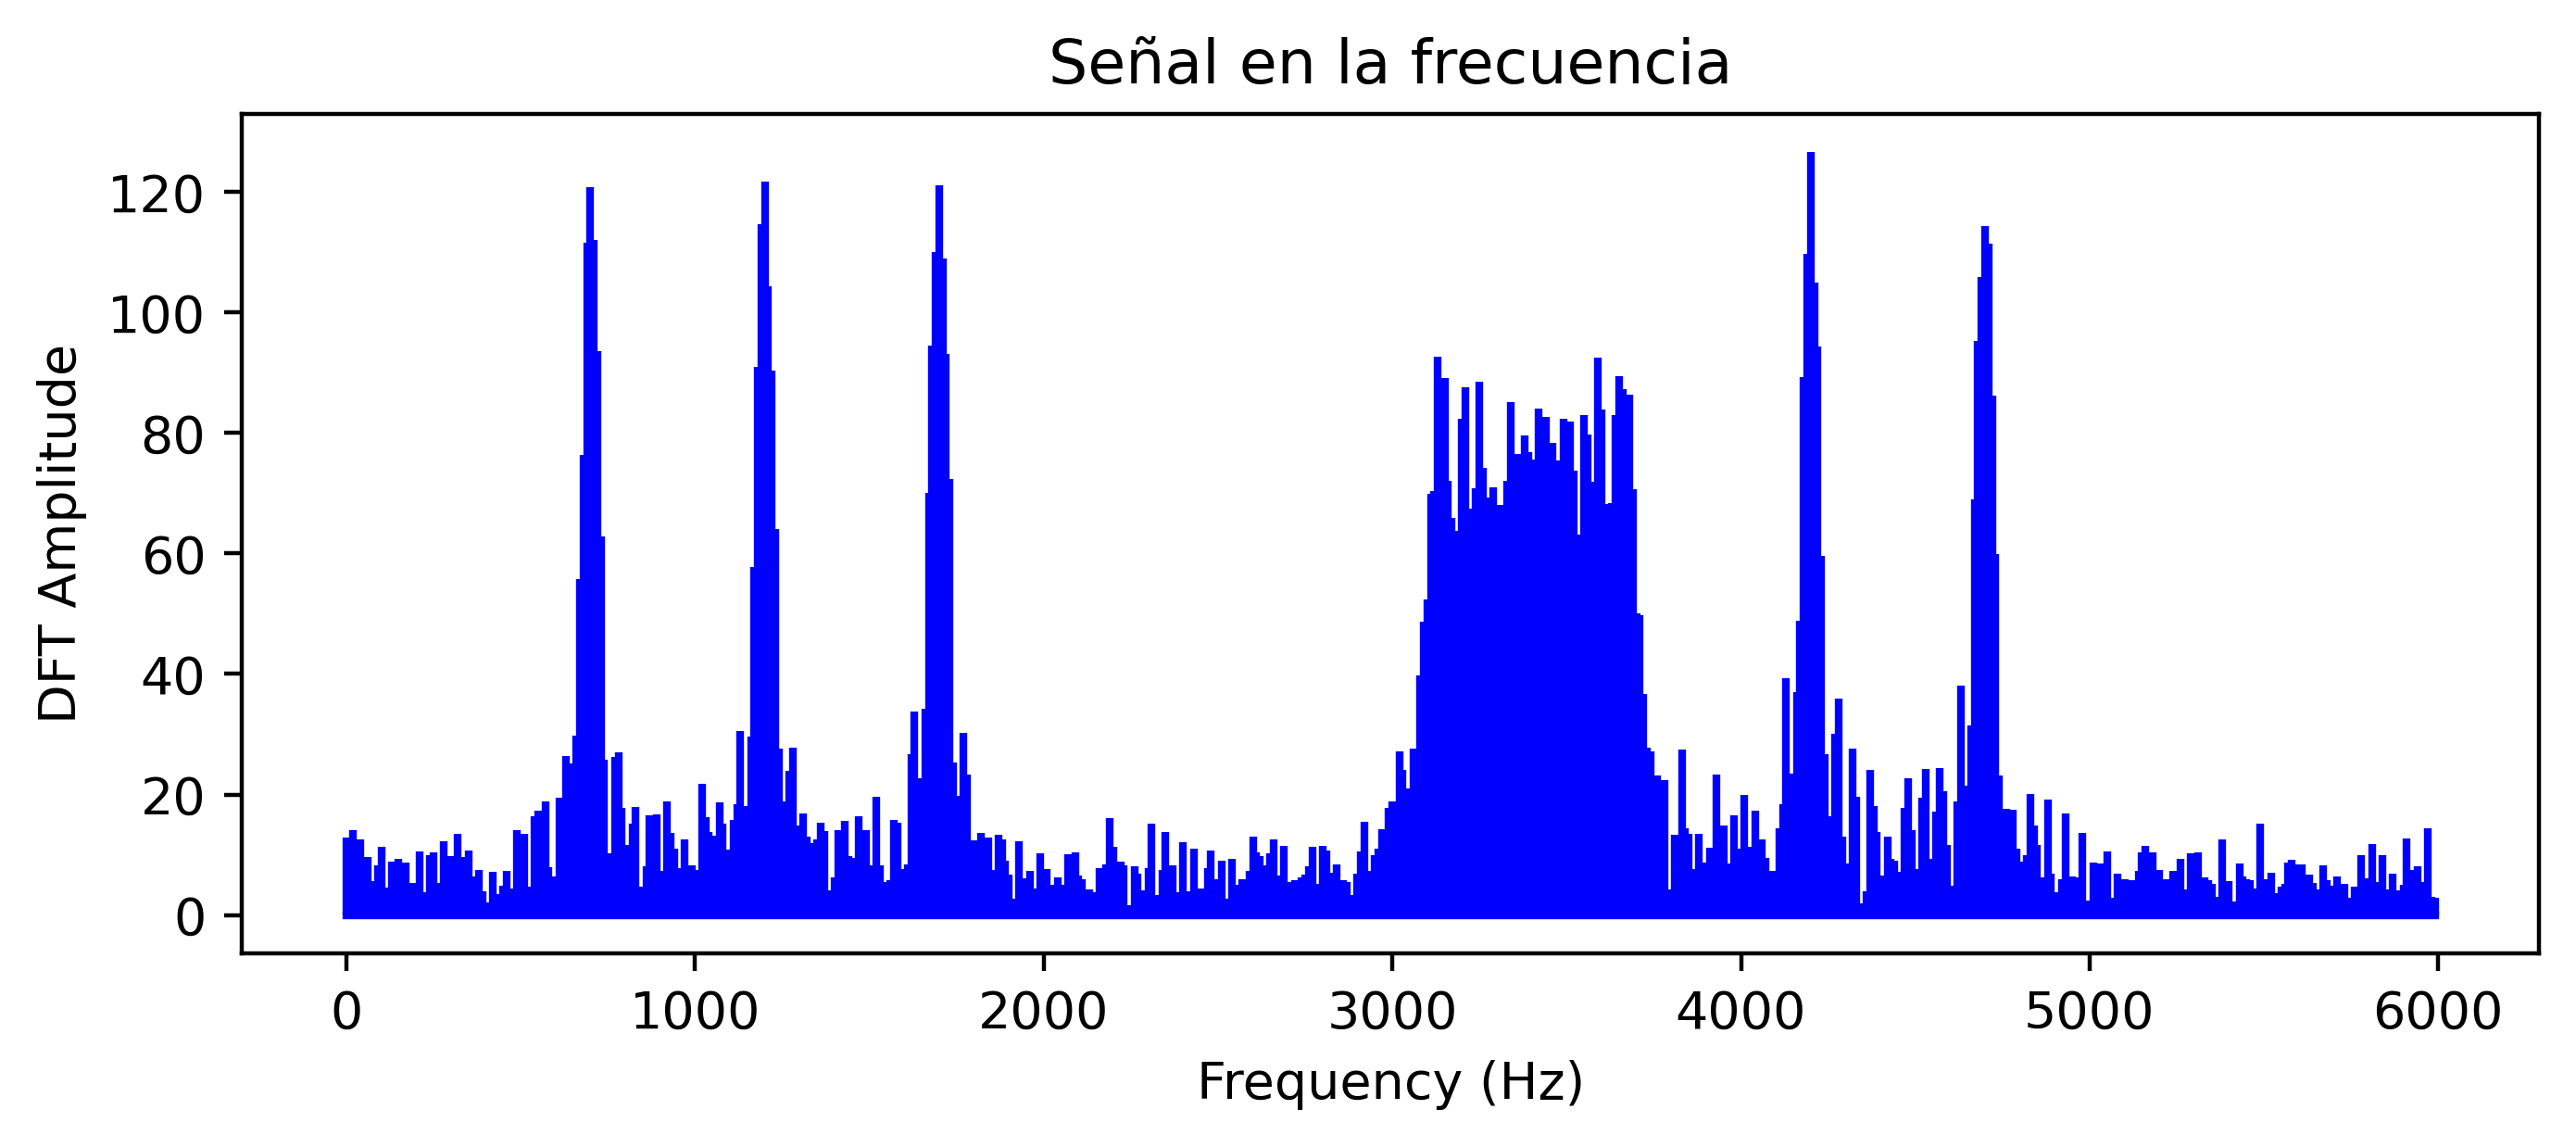

In [6]:
[IM, RE, Mag, Fase] = TDFdirecta(codificacion)

N = len(Mag)
n = np.arange(N)
T = N/fs
freq = n/T 

plt.figure(figsize = (8, 3), dpi = 400)
plt.stem(freq[0:int(N/2)], Mag[0:int(N/2)], 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Frequency (Hz)')
plt.ylabel('DFT Amplitude')
plt.title('Señal en la frecuencia')
plt.show()


In [7]:
f, t, Sxx = signal.spectrogram(tonemisterio, fs= fs)
F_peaks = f[np.argmax(Sxx, axis=0)]

decode_message = np.zeros(len(F_peaks))


for i in range(len(F_peaks)):
    
    _, decode_message[i] = find_nearest(f_digitos, F_peaks[i])


print('The message is: ', decode_message.astype(int))

The message is:  [3 9 8 1 2]
